---------------------------------------------------------------------
# Data Science with Python
## CAPSTONE PROJECT: Predict the price per night of an Airbnb in New York City
### By Roslyn Badilla
### March, 2020
---------------------------------------------------------------------
![title](airbnb.jpg)

### Libraries

In [170]:
#imports
import numpy as np
import pandas as pd
import scipy
import xgboost as xgb
import lightgbm as lgb
import time
import warnings
from math import sqrt

#Visualization
import wordcloud
import os
import matplotlib                  # 2D Plotting Library
import matplotlib.pyplot as plt
import seaborn as sns              # Python Data Visualization Library based on matplotlib
import geopandas as gpd            # Python Geospatial Data Library

from scipy import stats
from matplotlib import cm
from os import path
from PIL import Image
from wordcloud import WordCloud, ImageColorGenerator, STOPWORDS

%matplotlib inline

#Feature Engineering
from sklearn.preprocessing import LabelEncoder,RobustScaler

#Cross validation
from sklearn.model_selection import train_test_split

# Estimators
from sklearn.linear_model import Ridge, RidgeCV, LinearRegression, ElasticNet,  HuberRegressor
from sklearn.ensemble import RandomForestRegressor,  GradientBoostingRegressor
from xgboost import XGBRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.pipeline import make_pipeline

from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import mean_squared_error, r2_score

# 1-Description of Data

#### Since 2008, guests and hosts have used Airbnb to expand on traveling possibilities and present more unique, personalized way of experiencing the world. This dataset describes the listing activity and metrics in NYC, NY for 2019. 
#### This public dataset is part of Airbnb, and the original source can be found on http://insideairbnb.com/

#### In the cells below is showed the initial insights about the Airbnb data :



In [171]:
#data
rawdata = pd.read_csv('AB_NYC_2019.csv', header=0)

In [172]:
# Code for basic analysis
rawdata.head()

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,2539,Clean & quiet apt home by the park,2787,John,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,2018-10-19,0.21,6,365
1,2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,2019-05-21,0.38,2,355
2,3647,THE VILLAGE OF HARLEM....NEW YORK !,4632,Elisabeth,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,NaN,NaN,1,365
3,3831,Cozy Entire Floor of Brownstone,4869,LisaRoxanne,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,2019-07-05,4.64,1,194
4,5022,Entire Apt: Spacious Studio/Loft by central park,7192,Laura,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,2018-11-19,0.10,1,0


In [173]:
#basic metrics for numerical data
rawdata.describe()

,id,host_id,latitude,longitude,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365
count,4.889500e+04,4.889500e+04,48895.000000,48895.000000,48895.000000,48895.000000,48895.000000,38843.000000,48895.000000,48895.000000
mean,1.901714e+07,6.762001e+07,40.728949,-73.952170,152.720687,7.029962,23.274466,1.373221,7.143982,112.781327
std,1.098311e+07,7.861097e+07,0.054530,0.046157,240.154170,20.510550,44.550582,1.680442,32.952519,131.622289
min,2.539000e+03,2.438000e+03,40.499790,-74.244420,0.000000,1.000000,0.000000,0.010000,1.000000,0.000000
25%,9.471945e+06,7.822033e+06,40.690100,-73.983070,69.000000,1.000000,1.000000,0.190000,1.000000,0.000000
50%,1.967728e+07,3.079382e+07,40.723070,-73.955680,106.000000,3.000000,5.000000,0.720000,1.000000,45.000000
75%,2.915218e+07,1.074344e+08,40.763115,-73.936275,175.000000,5.000000,24.000000,2.020000,2.000000,227.000000
max,3.648724e+07,2.743213e+08,40.913060,-73.712990,10000.000000,1250.000000,629.000000,58.500000,327.000000,365.000000


In [174]:
# check values in categorical columns
rawdata.neighbourhood_group.unique()

array(['Brooklyn', 'Manhattan', 'Queens', 'Staten Island', 'Bronx'],
      dtype=object)

In [175]:
rawdata.neighbourhood.unique()

array(['Kensington', 'Midtown', 'Harlem', 'Clinton Hill', 'East Harlem',
       'Murray Hill', 'Bedford-Stuyvesant', "Hell's Kitchen",
       'Upper West Side', 'Chinatown', 'South Slope', 'West Village',
       'Williamsburg', 'Fort Greene', 'Chelsea', 'Crown Heights',
       'Park Slope', 'Windsor Terrace', 'Inwood', 'East Village',
       'Greenpoint', 'Bushwick', 'Flatbush', 'Lower East Side',
       'Prospect-Lefferts Gardens', 'Long Island City', 'Kips Bay',
       'SoHo', 'Upper East Side', 'Prospect Heights',
       'Washington Heights', 'Woodside', 'Brooklyn Heights',
       'Carroll Gardens', 'Gowanus', 'Flatlands', 'Cobble Hill',
       'Flushing', 'Boerum Hill', 'Sunnyside', 'DUMBO', 'St. George',
       'Highbridge', 'Financial District', 'Ridgewood',
       'Morningside Heights', 'Jamaica', 'Middle Village', 'NoHo',
       'Ditmars Steinway', 'Flatiron District', 'Roosevelt Island',
       'Greenwich Village', 'Little Italy', 'East Flatbush',
       'Tompkinsville', 'Asto

In [176]:
rawdata['neighbourhood'].nunique()

221

In [177]:
rawdata.room_type.unique()

array(['Private room', 'Entire home/apt', 'Shared room'], dtype=object)

In [178]:
rawdata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48895 entries, 0 to 48894
Data columns (total 16 columns):
id                                48895 non-null int64
name                              48879 non-null object
host_id                           48895 non-null int64
host_name                         48874 non-null object
neighbourhood_group               48895 non-null object
neighbourhood                     48895 non-null object
latitude                          48895 non-null float64
longitude                         48895 non-null float64
room_type                         48895 non-null object
price                             48895 non-null int64
minimum_nights                    48895 non-null int64
number_of_reviews                 48895 non-null int64
last_review                       38843 non-null object
reviews_per_month                 38843 non-null float64
calculated_host_listings_count    48895 non-null int64
availability_365                  48895 non-null int64

In [179]:
#check nulls

null_columns=rawdata.columns[rawdata.isnull().any()]

rawdata[null_columns].isnull().sum()

name                    16
host_name               21
last_review          10052
reviews_per_month    10052
dtype: int64

### Initial Analysis
- Data: AB_NYC_2019 has 16 features and 48895 observations.
- Features consist in 2 ID columns, 5 categorical columns, 1 date column, 3 float columns and 5 int columns.
- 4 columns have nulls: name, host name, reviews per month and last review. The first 2 aren't important and review columns lookslike can be empty if there are no reviews.

### Column description
- id: listing ID
- name: name of the listing contains NULLS
- host_id: host ID
- host_name: name of the host contains NULLS
- neighbourhood_group: location('Brooklyn', 'Manhattan', 'Queens', 'Staten Island', 'Bronx')
- neighbourhood: area (221 distinct neighbourhoods)
- latitude: latitude coordinates
- longitude: longitude coordinates
- room_type: listing space type ('Private room', 'Entire home/apt', 'Shared room')
- price: price in dollars
- minimum_nights: amount of nights minimum
- number_of_reviews: number of reviews
- last_review: date of latest review, contains NULLS
- reviews_per_month: number of reviews per month, contains NULLS
- calculated_host_listings_count: amount of listing per host
- availability_365: number of days when listing is available for booking

# 2- Cleaning and preprocessing
### Missing data
First, not needed columns as Host name and ID can be dropped. After that the Reviews per month with nulls can be filled with 0 and for last reviews is going to be used the oldest data in the dataset. 

In [180]:
#dropping columns that are not significant
rawdata.drop(['id','host_name'], axis=1, inplace=True)
rawdata.head()

,name,host_id,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,Clean & quiet apt home by the park,2787,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,2018-10-19,0.21,6,365
1,Skylit Midtown Castle,2845,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,2019-05-21,0.38,2,355
2,THE VILLAGE OF HARLEM....NEW YORK !,4632,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,NaN,NaN,1,365
3,Cozy Entire Floor of Brownstone,4869,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,2019-07-05,4.64,1,194
4,Entire Apt: Spacious Studio/Loft by central park,7192,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,2018-11-19,0.10,1,0


In [181]:
#Replacing NULLS in Reviews_per_month with 0's
rawdata.fillna({'reviews_per_month':0}, inplace=True)
rawdata.reviews_per_month.isnull().sum()

0

In [182]:
#Replacing NULLS in last_review with minimun date

#change to date format
rawdata['last_review'] = pd.to_datetime(rawdata['last_review'],infer_datetime_format=True) 

min_date = min(rawdata['last_review'])
rawdata['last_review'] = rawdata['last_review'].fillna(min_date)
rawdata['last_review'] = rawdata['last_review'].apply(lambda x: x.toordinal() - min_date.toordinal())
rawdata.last_review.isnull().sum()

0

In [183]:
#check nulls again - only name column remain with nulls

null_columns=rawdata.columns[rawdata.isnull().any()]

rawdata[null_columns].isnull().sum()

name    16
dtype: int64

### Outliers

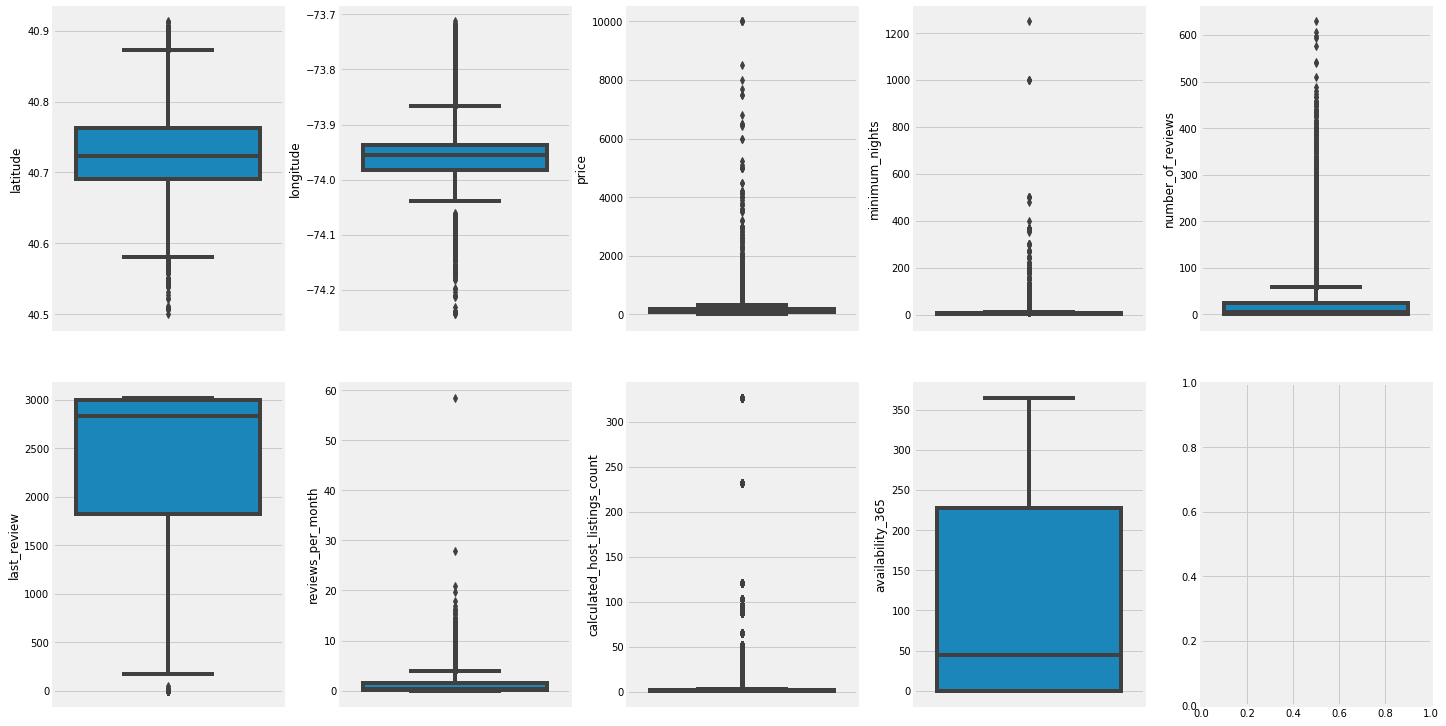

In [184]:
num_features = ['latitude','longitude','price','minimum_nights','number_of_reviews','last_review',
                'reviews_per_month','calculated_host_listings_count','availability_365']
num_df = rawdata[num_features].copy()

fig, axs = plt.subplots(ncols=5, nrows=2, figsize=(20, 10))
index = 0
axs = axs.flatten()
for k,v in num_df.items():
    sns.boxplot(y=k, data=rawdata, ax=axs[index])
    index += 1
plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=5.0)

In [185]:
for k, v in num_df.items():
        q1 = v.quantile(0.25)
        q3 = v.quantile(0.75)
        irq = q3 - q1
        v_col = v[(v <= q1 - 1.5 * irq) | (v >= q3 + 1.5 * irq)]
        perc = np.shape(v_col)[0] * 100.0 / np.shape(num_df)[0]
        print("Column %s outliers = %.2f%%" % (k, perc))

Column latitude outliers = 0.87%
Column longitude outliers = 5.79%
Column price outliers = 6.09%
Column minimum_nights outliers = 13.58%
Column number_of_reviews outliers = 12.31%
Column last_review outliers = 20.56%
Column reviews_per_month outliers = 6.81%
Column calculated_host_listings_count outliers = 14.48%
Column availability_365 outliers = 0.00%


The features like Price, minimum nights, number of reviews,reviews per month and calculated host listings have outliers, so it is important to remove those observations first.

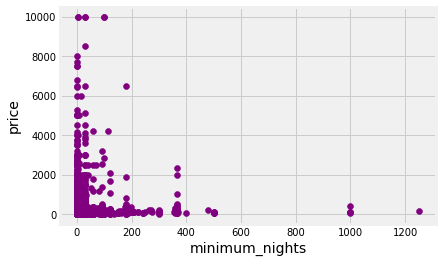

In [186]:
fig, ax = plt.subplots()
ax.scatter(x = rawdata['minimum_nights'], y = rawdata['price'], color = 'purple')
plt.ylabel('price', fontsize=14)
plt.xlabel('minimum_nights', fontsize=14)
plt.show()

In [187]:
#Remove most noticeable outliers
rawdata = rawdata[~(rawdata['minimum_nights'] >= 800)]

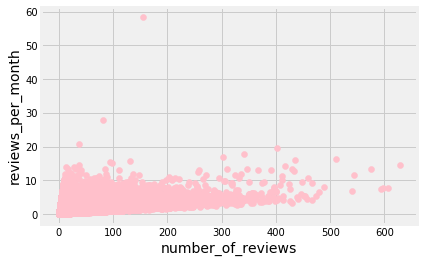

In [188]:
fig, ax = plt.subplots()
ax.scatter(x = rawdata['number_of_reviews'], y = rawdata['reviews_per_month'], color = 'pink')
plt.ylabel('reviews_per_month', fontsize=14)
plt.xlabel('number_of_reviews', fontsize=14)
plt.show()

In [189]:
#Remove most noticeable outliers
rawdata = rawdata[~(rawdata['reviews_per_month'] >= 50)]

### Distribution

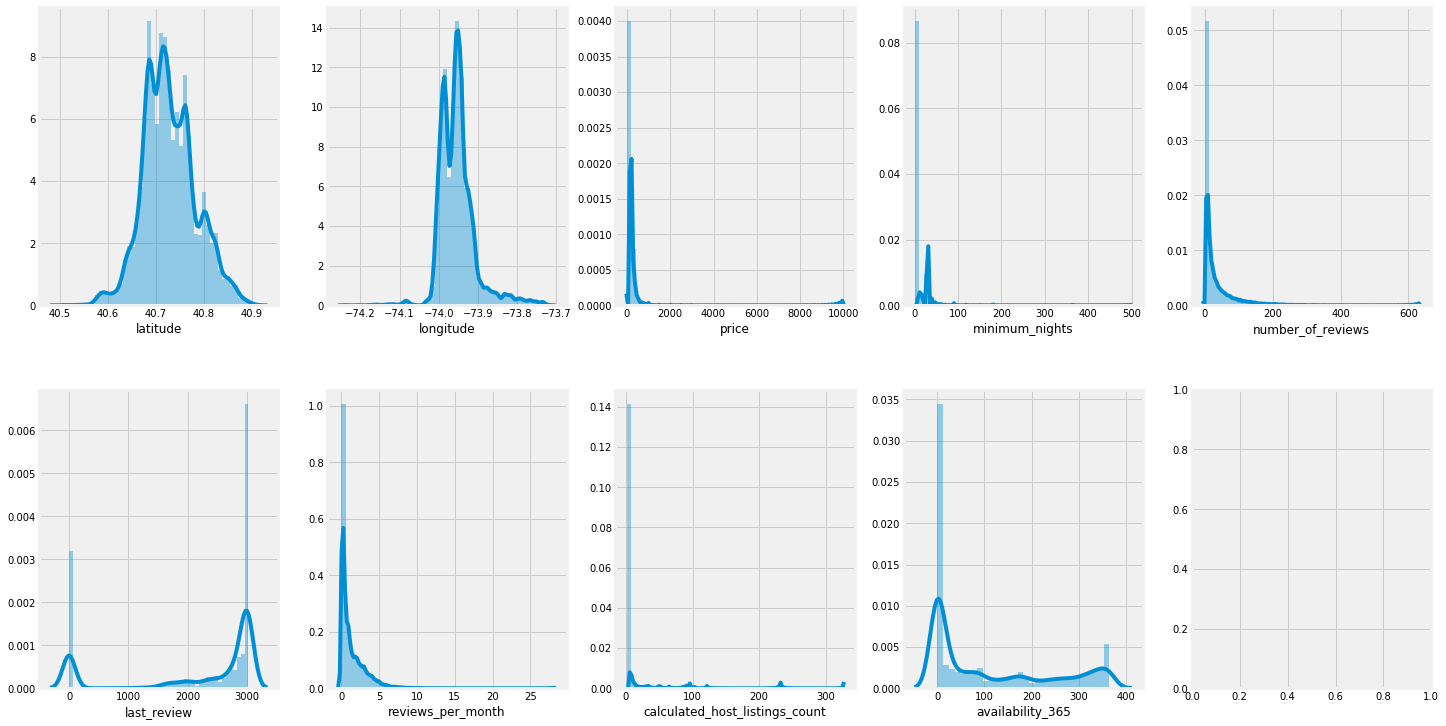

In [190]:
#check distributions
num_features = ['latitude','longitude','price','minimum_nights','number_of_reviews','last_review',
                'reviews_per_month','calculated_host_listings_count','availability_365']
num_df = rawdata[num_features].copy()

fig, axs = plt.subplots(ncols=5, nrows=2, figsize=(20, 10))
index = 0
axs = axs.flatten()
for k,v in num_df.items():
    sns.distplot(v, ax=axs[index])
    index += 1
plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=5.0)

#### Insights:
-Price variable is going to be our target variable and is showing a highly skewed distribution, so to fix this issue a log transformation is going to be applied.

-Minimum nights can be transform to Log as price.

-For review variables, is better to keep the data as it is, because the reviews depends of a lot of factors like availability, price and time on Airbnb platform

Text(0.5, 0, 'log(1+price)')

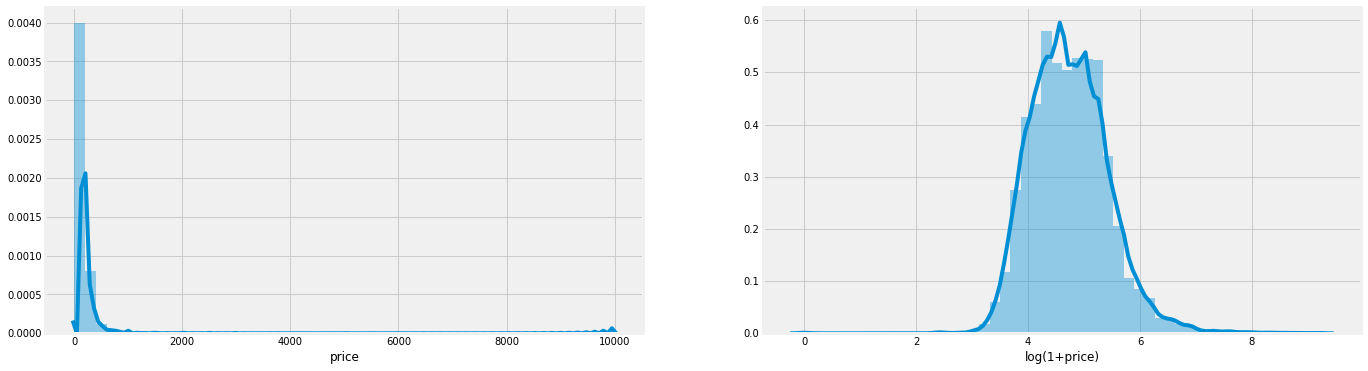

In [191]:
fig, axes = plt.subplots(1,2, figsize=(21,6))
sns.distplot(rawdata['price'], ax=axes[0])
sns.distplot(np.log1p(rawdata['price']), ax=axes[1])
axes[1].set_xlabel('log(1+price)')

In [192]:
#fit the curve
rawdata = rawdata[np.log1p(rawdata['price']) < 8]
rawdata = rawdata[np.log1p(rawdata['price']) > 3]

Text(0.5, 0, 'log(1+price)')

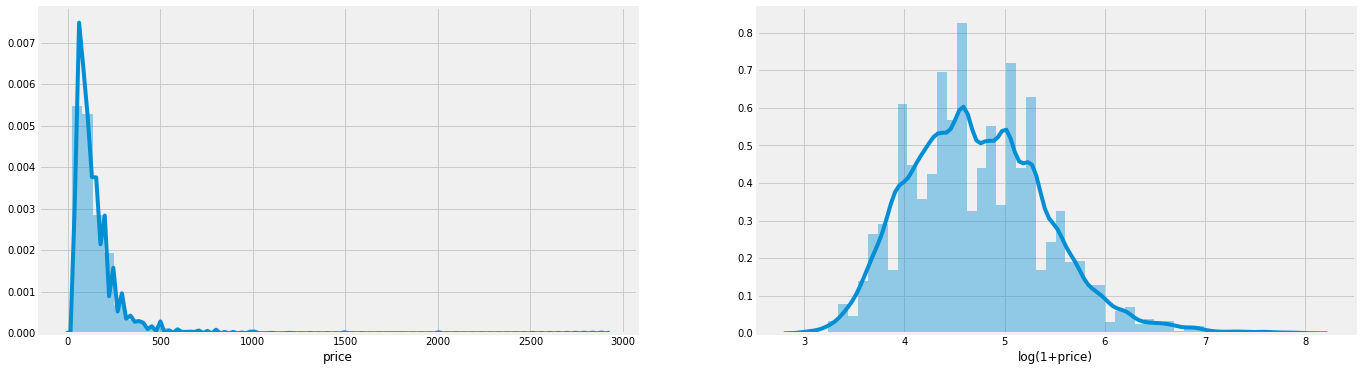

In [193]:
#check again
fig, axes = plt.subplots(1,2, figsize=(21,6))
sns.distplot(rawdata['price'], ax=axes[0])
sns.distplot(np.log1p(rawdata['price']), ax=axes[1])
axes[1].set_xlabel('log(1+price)')

In [194]:
#Apply Log to price
rawdata['price'] = np.log1p(rawdata['price'])

Text(0.5, 0, 'log(1+min nights)')

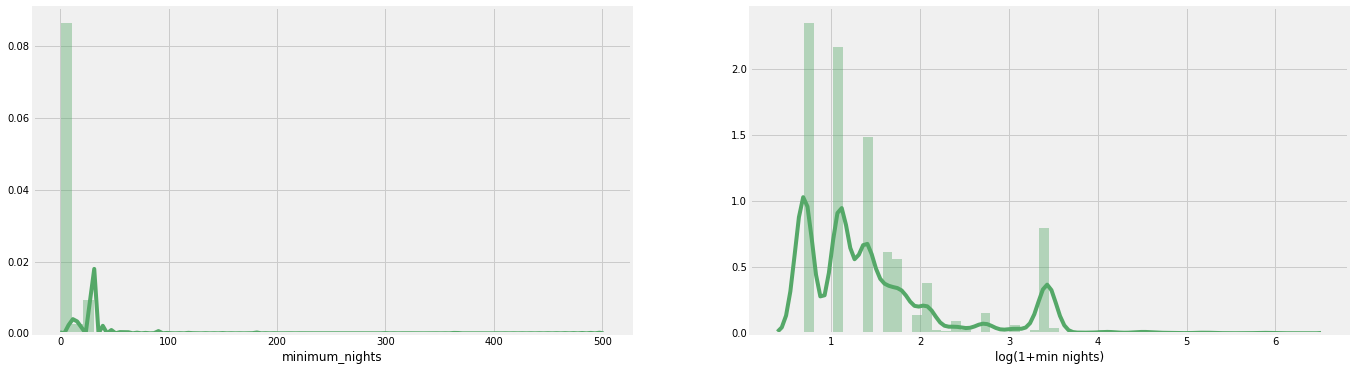

In [195]:
#Check minimum nights as Log
sns.set_color_codes()
fig, axes = plt.subplots(1,2, figsize=(21,6))
sns.distplot(rawdata['minimum_nights'], ax=axes[0],color="g")
sns.distplot(np.log1p(rawdata['minimum_nights']), ax=axes[1],color="g")
axes[1].set_xlabel('log(1+min nights)')

In [196]:
#No need to fit the curve, applied as shown above
rawdata['minimum_nights'] = np.log1p(rawdata['minimum_nights'])

In [197]:
#Save data with preprocessing steps
rawdata.to_csv (r'C:\Users\rosbadil\Desktop\Roslyn\BigData-Xtol\5-Python\CodeRepository\airbnb_pre.csv', index = False, header=True)

# 3-Covariance and Correlation

In [198]:
#data
rawdata = pd.read_csv('airbnb_pre.csv', header=0)

(10.0, 0.0)

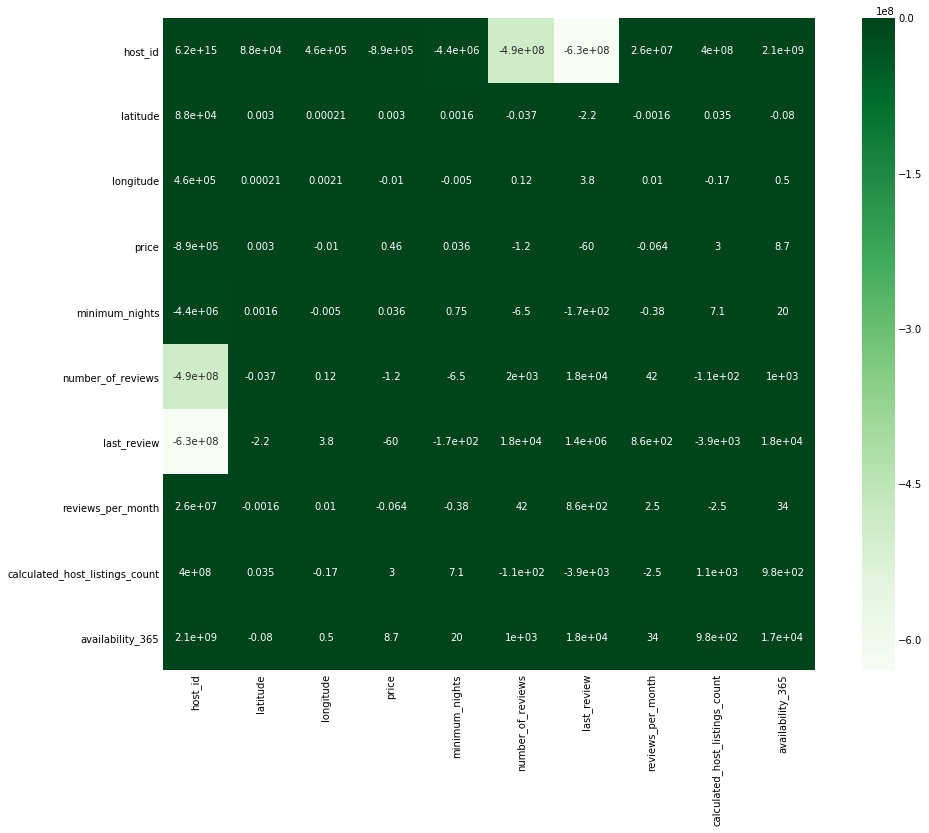

In [199]:
covmat = rawdata.cov()
plt.figure(figsize=(15,12))
ax = sns.heatmap(covmat, vmax=0.8, square=True, annot=True, cmap="Greens")
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)

(10.0, 0.0)

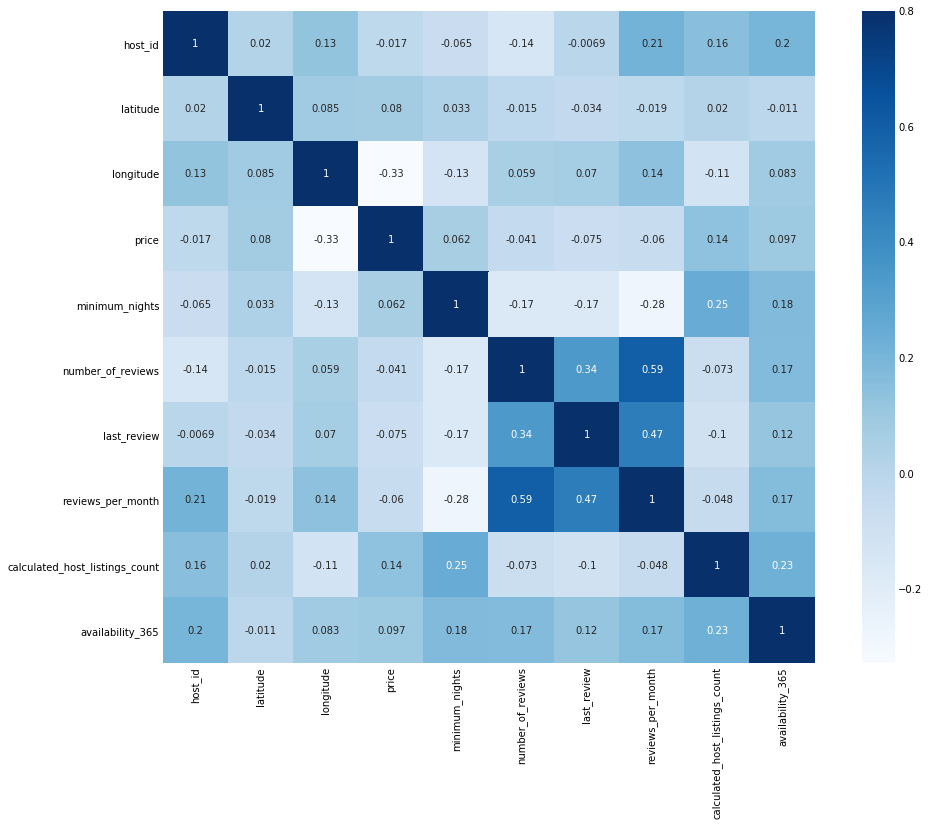

In [200]:
corrmat = rawdata.corr()
plt.figure(figsize=(15,12))
ax = sns.heatmap(corrmat, vmax=0.8, square=True, annot=True, cmap="Blues")
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)

The matrix above doesn't show highly correlated features. But the review variables shows correlations of 34% to 59%, which make sense but it's important to notice.

# 4- Exploratory Data Analysis
#### Until now, we know data's size, outliers, missing data, features distributions and some features have been transformed into log variables. Now is time to understand the categorical data and the relationship with the target variable

Text(0.5, 1.0, 'Airbnbs per Host')

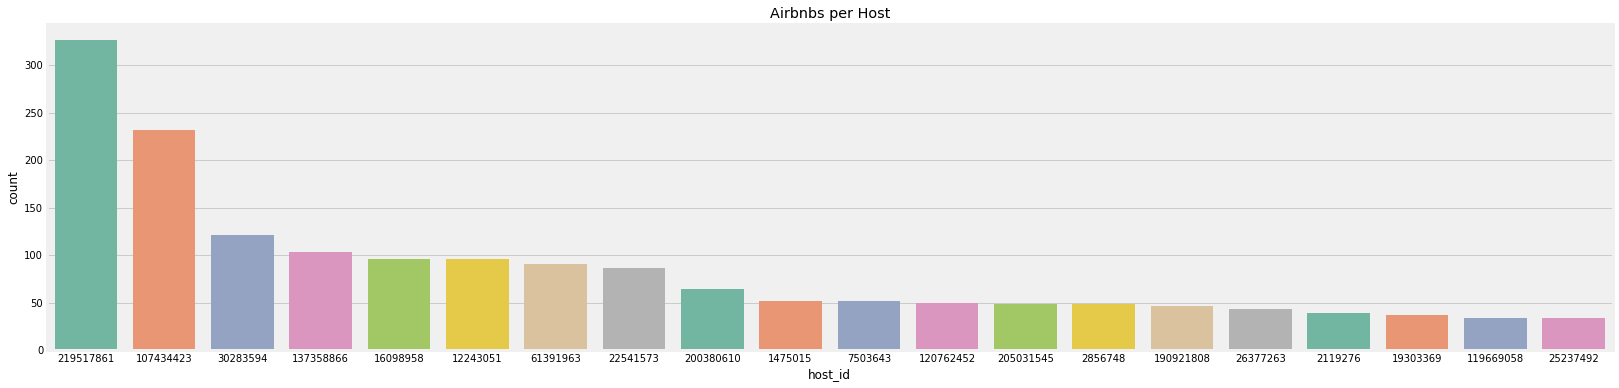

In [201]:
#Airbnbs per host
sns.countplot(rawdata['host_id'],order=rawdata['host_id'].value_counts().iloc[:20].index,palette='Set2')
fig = plt.gcf()
fig.set_size_inches(25,6)
plt.title('Airbnbs per Host')

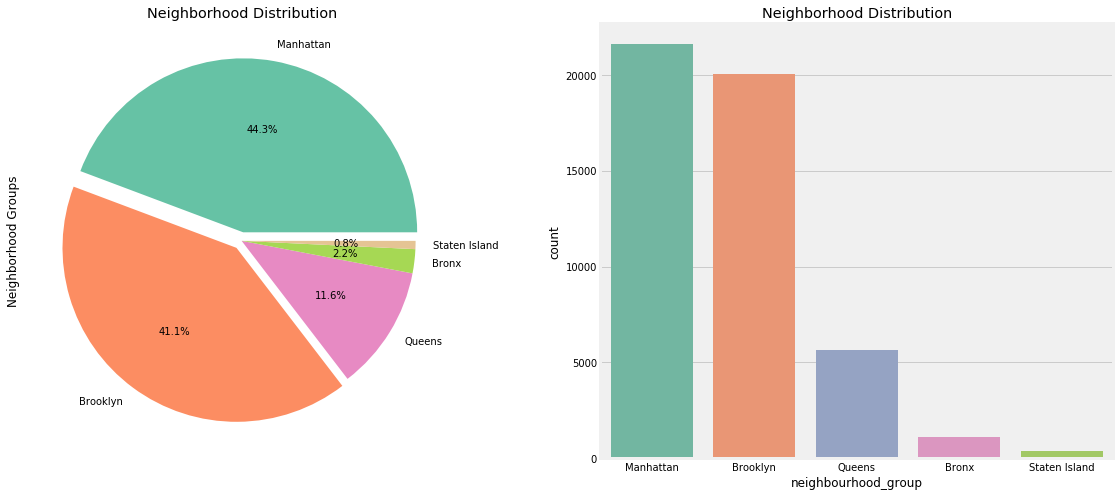

In [202]:
#Neighbourhood Group charts
cs=cm.Set2(np.arange(5)/5.)
f,ax=plt.subplots(1,2,figsize=(18,8))
rawdata['neighbourhood_group'].value_counts().plot.pie(explode=[0.05,0.05,0,0,0],autopct='%1.1f%%',ax=ax[0],colors=cs)
ax[0].set_title('Neighborhood Distribution')
ax[0].set_ylabel('Neighborhood Groups')
sns.countplot('neighbourhood_group',data=rawdata,ax=ax[1],order=rawdata['neighbourhood_group'].value_counts().index,
             palette="Set2")
ax[1].set_title('Neighborhood Distribution')
plt.show()



<Figure size 864x576 with 0 Axes>

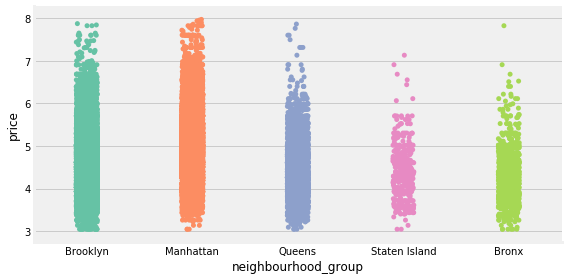

In [203]:
plt.figure(figsize=(12,8))
sns.catplot(y='price', x='neighbourhood_group', data=rawdata, height=4, aspect=2,palette="Set2");
plt.ioff()

Manhattan is the most densely populated of New York City’s 5 boroughs, therefore is not a surprise that most of the airbnb's are located there. Another highlight for Manhattan are the iconic sites like Times Square, Broadway and the Empire State

Text(0.5, 1.0, 'Neighbourhood')

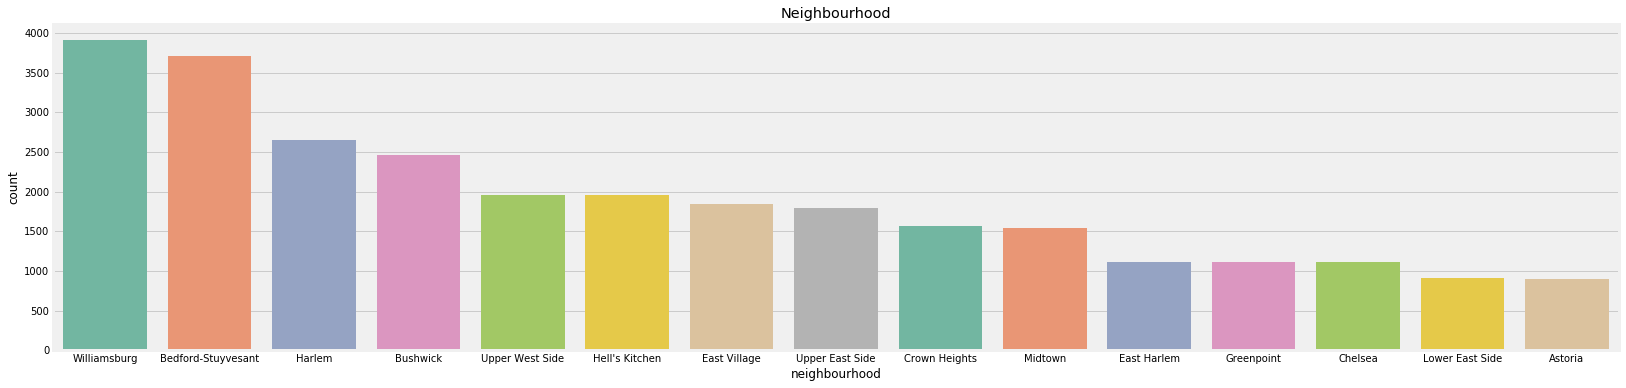

In [204]:
#Top 15 Neighbourhoods(221 Total)
sns.countplot(rawdata['neighbourhood'],order=rawdata['neighbourhood'].value_counts().iloc[:15].index,palette='Set2')
fig = plt.gcf()
fig.set_size_inches(25,6)
plt.title('Neighbourhood')

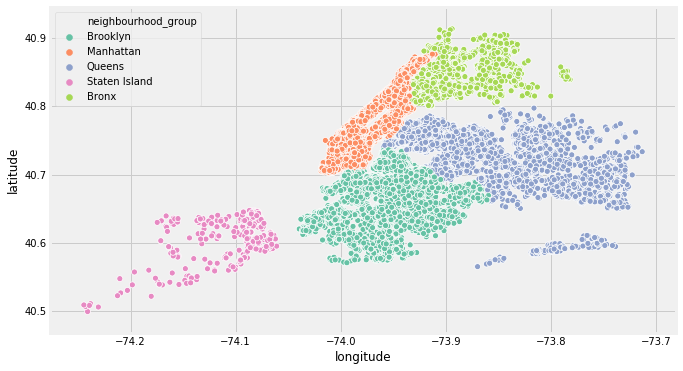

In [205]:
#Neighbourhoods by boroughs
plt.figure(figsize=(10,6))
sns.scatterplot(rawdata.longitude,rawdata.latitude,hue=rawdata.neighbourhood_group, palette="Set2")
plt.ioff()

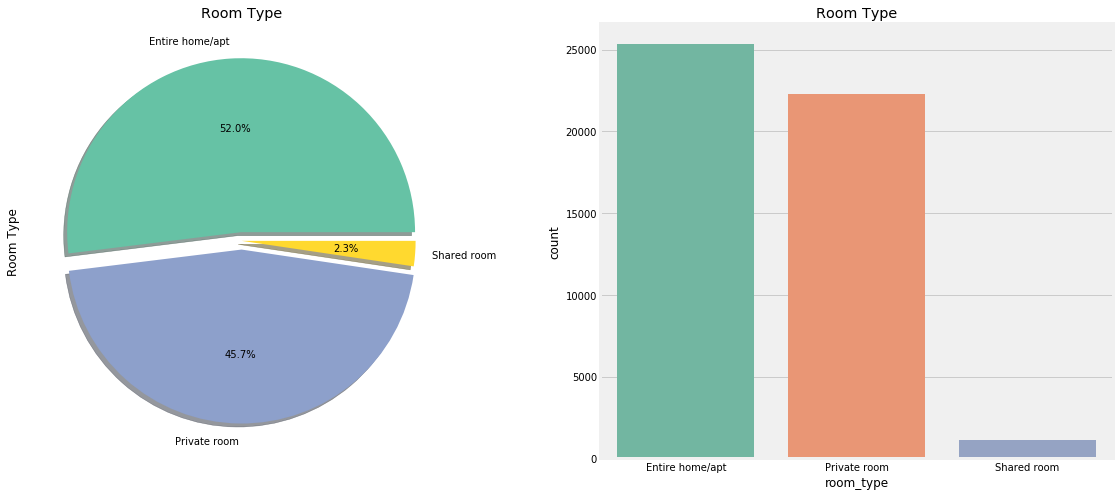

In [206]:
#Room types 
cs=cm.Set2(np.arange(3)/3.)
f,ax=plt.subplots(1,2,figsize=(18,8))
rawdata['room_type'].value_counts().plot.pie(explode=[0.05,0.05,0],autopct='%1.1f%%',ax=ax[0],shadow=True, colors = cs)
ax[0].set_title('Room Type')
ax[0].set_ylabel('Room Type')
sns.countplot('room_type',data=rawdata,ax=ax[1],order=rawdata['room_type'].value_counts().index, palette = "Set2")
ax[1].set_title('Room Type')
plt.show()

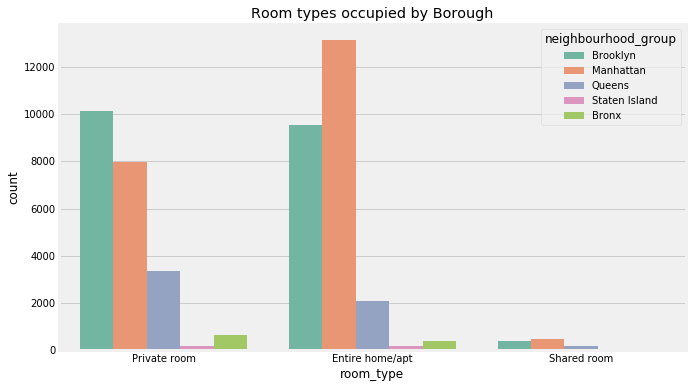

In [207]:
#Room type per Neighbourhood_group
plt.figure(figsize=(10,6))
sns.countplot(x = 'room_type',hue = "neighbourhood_group",data = rawdata, palette="Set2")
plt.title("Room types occupied by Borough")
plt.show()

Brooklyn has 9559 entire homes or apartaments and 10132 private rooms, this means that Brooklyn has almost the same quantity of entire homes or apartaments and private rooms(48% and 50%)
For Manhattan the room types differ, it has 13199 entire homes or apartaments and 7982 of Private rooms, this means 61% of  entire homes or parataments versus 37% of private rooms

<Figure size 720x432 with 0 Axes>

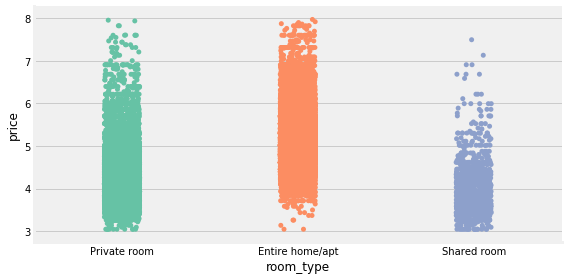

In [208]:
#Prices per Room Type
plt.figure(figsize=(10,6))
sns.catplot(x="room_type", y="price", data=rawdata, height=4, aspect=2,palette="Set2");
plt.ioff()

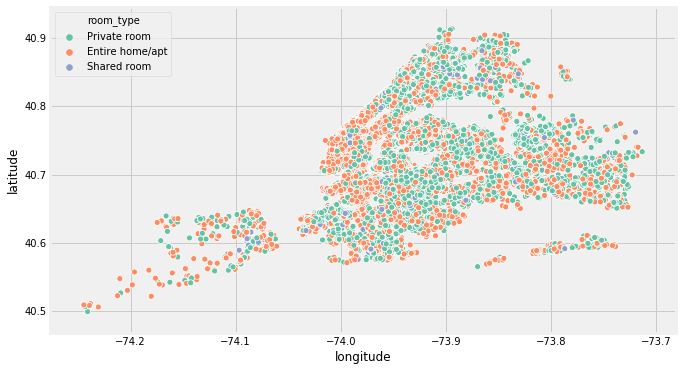

In [209]:
#Room type per Longitude and latitude
plt.figure(figsize=(10,6))
sns.scatterplot(rawdata.longitude,rawdata.latitude,hue=rawdata.room_type,palette = "Set2")
plt.ioff()

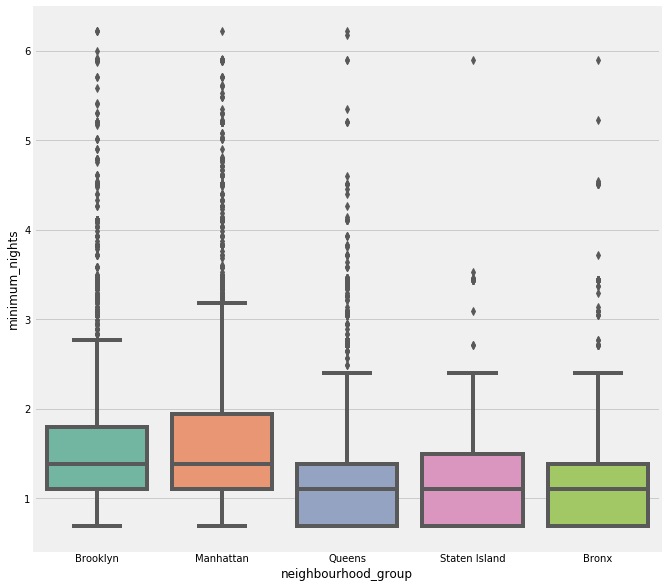

In [210]:
#Minimun Nights per Borough
plt.figure(figsize=(10,10))
ax = sns.boxplot(data=rawdata, x='neighbourhood_group',y='minimum_nights',palette='Set2')

For Minimum Nights, the chart shows the logarithmic scale, but as we saw at the beggining of the Notebook the mininum nights required for most of the Airbnbs is 1, 13 airbnb's requires more than 365 days and 2 of them requires more than 1000 days, what sounds like a mistake.

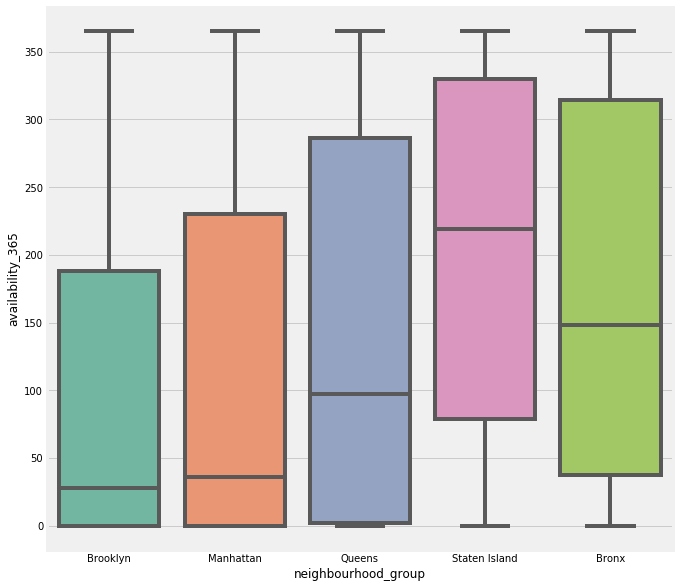

In [211]:
#Availalabity 365 per Borough
plt.figure(figsize=(10,10))
ax = sns.boxplot(data=rawdata, x='neighbourhood_group',y='availability_365',palette='Set2')

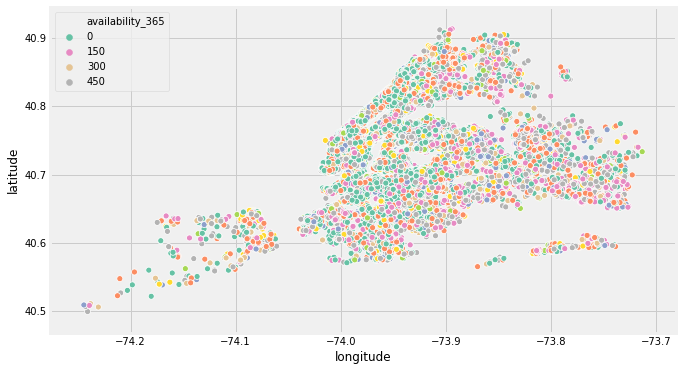

In [212]:
plt.figure(figsize=(10,6))
sns.scatterplot(rawdata.longitude,rawdata.latitude,hue=rawdata.availability_365, palette = "Set2")
plt.ioff()

<Figure size 720x432 with 0 Axes>

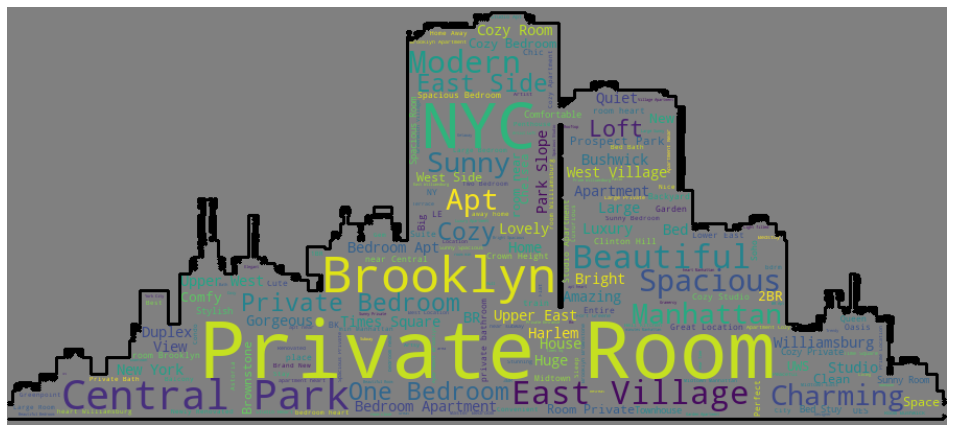

In [213]:
#word cloud

# get data directory (using getcwd() is needed to support running example in generated IPython notebook)
d = path.dirname(__file__) if "__file__" in locals() else os.getcwd()

#get words
text = " ".join(str(each) for each in rawdata.name)

#image to create the mask (https://clipartmag.com/image/nyc-skyline-drawing-33.jpg)
statue_mask = np.array(Image.open(path.join(d, "statue.jpg")))

stopwords = set(STOPWORDS)
stopwords.add("said")


# Create and generate a word cloud image:
wordcloud = WordCloud(max_words=200, background_color="gray",mask=statue_mask,
               stopwords=stopwords, contour_width=3, contour_color='black').generate(text)
plt.figure(figsize=(10,6))
plt.figure(figsize=(15,10))

# store to file
wordcloud.to_file(path.join(d, "word.png"))

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

# 5- Feature Engineering
#### With a better understanding of the data, now we are going to transform some features to dummy variables and select our final dataset

In [214]:
#dropping columns again, because above were needed for plotting, but not useful in the prediction
rawdata.drop(['name','host_id'], axis=1, inplace=True)
rawdata.head()

,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,Brooklyn,Kensington,40.64749,-73.97237,Private room,5.010635,0.693147,9,2762,0.21,6,365
1,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,5.420535,0.693147,45,2976,0.38,2,355
2,Manhattan,Harlem,40.80902,-73.94190,Private room,5.017280,1.386294,0,0,0.00,1,365
3,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,4.499810,0.693147,270,3021,4.64,1,194
4,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,4.394449,2.397895,9,2793,0.10,1,0


In [215]:
# Create a variable with the Airbnbs with No Reviews
rawdata['no_reviews'] = rawdata['reviews_per_month']==0
rawdata['no_reviews'] = (rawdata['no_reviews']).astype(int)

In [216]:
#Label Encoding to neighbourhoods instead of dummify(to not crate a lot of variables)
# process columns, apply LabelEncoder to categorical features
lbl = LabelEncoder() 
lbl.fit(rawdata['neighbourhood'].values)
rawdata['neighbourhood'] = lbl.transform(rawdata['neighbourhood'].values)
rawdata['neighbourhood'].dtypes

dtype('int32')

# 6- One Hot Encoding

In [217]:
#include Categorical features in a DF
dummy_vars = rawdata.select_dtypes(include=['object'])
dummy_vars

,neighbourhood_group,room_type
0,Brooklyn,Private room
1,Manhattan,Entire home/apt
2,Manhattan,Private room
3,Brooklyn,Entire home/apt
4,Manhattan,Entire home/apt
...,...,...
48773,Brooklyn,Private room
48774,Brooklyn,Private room
48775,Manhattan,Entire home/apt
48776,Manhattan,Shared room


In [218]:
#One Hot Encoding -  neighbourhood_group and room_type
dummy_vars_onehot = pd.get_dummies(dummy_vars)
dummy_vars_onehot.head()

,neighbourhood_group_Bronx,neighbourhood_group_Brooklyn,neighbourhood_group_Manhattan,neighbourhood_group_Queens,neighbourhood_group_Staten Island,room_type_Entire home/apt,room_type_Private room,room_type_Shared room
0,0,1,0,0,0,0,1,0
1,0,0,1,0,0,1,0,0
2,0,0,1,0,0,0,1,0
3,0,1,0,0,0,1,0,0
4,0,0,1,0,0,1,0,0


In [219]:
#merge dummies and integers
num_vars = ['neighbourhood','latitude','longitude','minimum_nights','number_of_reviews',
            'last_review','reviews_per_month','calculated_host_listings_count','availability_365','no_reviews']
numerical = rawdata[num_vars].copy()
X = pd.concat([numerical, dummy_vars_onehot], axis=1)
y = rawdata['price']

final_data = pd.concat([df, y], axis = 1)
final_data.to_csv('NYC_Airbnb_final.csv')

# 7- Model Selection - Regression

### Train/Test split

In [220]:
#Split the data Train 70% /test 30% 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=81)

In [221]:
print('Training Set - features: {}'.format(X_train.shape))
print('Training Set - target: {}'.format(y_train.shape))
print('Test Set - features: {}'.format(X_test.shape))
print('Test Set - target: {}'.format(y_test.shape))

Training Set - features: (34144, 18)
Training Set - target: (34144,)
Test Set - features: (14634, 18)
Test Set - target: (14634,)


### Cross Validation

In [222]:
#Validation function
n_folds = 5

def rmsle_cv(model):
    kf = KFold(n_folds, shuffle=True, random_state=81).get_n_splits(X_train.values)
    rmse= np.sqrt(-cross_val_score(model, X_train.values, y_train, scoring="neg_mean_squared_error", cv = kf))
    return(rmse)

In [223]:
n_folds = 5

# squared_loss
def rmse_cv(model):
    kf = KFold(n_folds, shuffle=True, random_state = 91).get_n_splits(X_train.values)
    return cross_val_score(model, X_train, y_train, scoring='neg_mean_squared_error', cv=kf)

def rmse_lv_cv(model):
    kf = KFold(n_folds, shuffle=True, random_state = 91).get_n_splits(X_train.values)
    return cross_val_score(model, Xlv_train, y_train, scoring='neg_mean_squared_error', cv=kf)

### Models
##### The models to be used will be:
- Linear Regression
- XGBRegressor
- Random Forest Regresor
- Elastic Net Regression
- Huber Regressor
- Ridge Regression

### Models out of the box

In [224]:
warnings.filterwarnings('ignore')

t1 = time.process_time()

for Model in [LinearRegression, XGBRegressor, RandomForestRegressor,ElasticNet,HuberRegressor, Ridge]:
    if Model == XGBRegressor: cv_res = rmse_cv(XGBRegressor(objective='reg:squarederror'))
    else: cv_res = rmse_cv(Model())
    print('{}: {:.5f} +/- {:5f}'.format(Model.__name__, -cv_res.mean(), cv_res.std()))
    
((time.process_time())-t1)/60

LinearRegression: 0.21932 +/- 0.003232
XGBRegressor: 0.18563 +/- 0.003466
RandomForestRegressor: 0.19546 +/- 0.003155
ElasticNet: 0.43768 +/- 0.005405
HuberRegressor: 0.24824 +/- 0.004104
Ridge: 0.21933 +/- 0.003246


0.5393229166666667

The best model "out of the box" is XGB Regressor, so we are going to tune this models in next steps

# 8- Model Tuning - XGB Regressor

In [225]:
#Check values out of the box
xgb_ootb = XGBRegressor(n_estimators=1000, learning_rate=0.05, early_stopping=5)
kf = KFold(n_folds, shuffle=True, random_state = 91).get_n_splits(X_train.values)
cv_res = cross_val_score(xgb_ootb, X_train, y_train, scoring='neg_mean_squared_error', cv=kf)
xgb_ootb.fit(X_train, y_train)

y_train_xgb_ootb = xgb_ootb.predict(X_train)

y_test_xgb_ootb = xgb_ootb.predict(X_test)
xgb_ootb_results = pd.DataFrame({'algorithm':['XGBRegressor[baseline]'],
            'CV error': cv_res.mean(), 
            'CV std': cv_res.std(),
            'training error': [mean_squared_error(y_train_xgb_ootb, y_train)]})

[09:45:10] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[09:45:23] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[09:45:38] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[09:45:52] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[09:46:06] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[09:46:20] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [226]:
print(xgb_ootb)
xgb_ootb_results

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, early_stopping=5, gamma=0,
             importance_type='gain', learning_rate=0.05, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=1000,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=1)


,algorithm,CV error,CV std,training error
0,XGBRegressor[baseline],-0.178224,0.003564,0.162577


Now to get the best parameters we will use learning rate, this is a tuning parameter that determines the step size at each iteration while moving toward a minimum of a loss function.

In [227]:
t1 = time.process_time()

d = {'Learning Rate':[],
            'Mean CV Error': [],
            'CV Error Std': [],
            'Training Error': []}
for lr in [0.01, 0.05, 0.1, 0.5]:
    xgb_model = XGBRegressor(n_estimators=1000, learning_rate=lr, early_stopping=5)
    cv_res = -cross_val_score(xgb_model, X_train, y_train, scoring='neg_mean_squared_error', cv=kf)
    xgb_model.fit(X_train, y_train)
    y_train_xgb = xgb_model.predict(X_train)
    d['Learning Rate'].append(lr)
    d['Mean CV Error'].append(cv_res.mean())
    d['CV Error Std'].append(cv_res.std())
    d['Training Error'].append(mean_squared_error(y_train_xgb, y_train))

((time.process_time())-t1)/60

[09:46:38] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[09:46:52] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[09:47:07] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[09:47:21] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[09:47:37] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[09:47:51] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[09:48:12] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[09:48:26] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[09:48:40] WARNING: src/objective/regression_obj.cu:152: reg:linear is n

6.030729166666666

In [228]:
#Results
d

{'Learning Rate': [0.01, 0.05, 0.1, 0.5],
 'Mean CV Error': [0.18578026876997927,
  0.1782238238432569,
  0.17715346172362495,
  0.19402192384413186],
 'CV Error Std': [0.0034378164530979123,
  0.003564222859044807,
  0.0034146317207484488,
  0.0031213975239068425],
 'Training Error': [0.18057338390724,
  0.16257666774690524,
  0.15131755243084838,
  0.10729620801199354]}

In [229]:
#Pass the results
xgb_tuning = pd.DataFrame(d)
xgb_tuning

,Learning Rate,Mean CV Error,CV Error Std,Training Error
0,0.01,0.185780,0.003438,0.180573
1,0.05,0.178224,0.003564,0.162577
2,0.10,0.177153,0.003415,0.151318
3,0.50,0.194022,0.003121,0.107296


After getting the learning rate, let's continue optimizing Max Depth and Min Child

In [230]:
t1 = time.process_time()
d = {'max_depth':[],
             'min_child_weight': [],
            'Mean CV Error': [],
            'CV Error Std': [],
            'Training Error': []}

xgbreg = XGBRegressor(n_estimators=2, learning_rate=0.05, early_stopping=5)
params2 = {'max_depth': list(range(3,10,2)), 'min_child_weight': list(range(1,6,2))}

kf = KFold(n_folds, shuffle=True, random_state = 81).get_n_splits(X_train)

for md in params2['max_depth']:
    for mcw in params2['min_child_weight']:
        xgb_model = XGBRegressor(n_estimators=1000, learning_rate=0.1, early_stopping=5, max_depth=md, min_child_weight=mcw )
        cv_res = -cross_val_score(xgb_model, X_train, y_train, scoring='neg_mean_squared_error', cv=kf)
        xgb_model.fit(X_train, y_train)
        y_train_xgb = xgb_model.predict(X_train)
        d['max_depth'].append(md)
        d['min_child_weight'].append(mcw)
        d['Mean CV Error'].append(cv_res.mean())
        d['CV Error Std'].append(cv_res.std())
        d['Training Error'].append(mean_squared_error(y_train_xgb, y_train))
        
((time.process_time())-t1)/60

[09:52:38] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[09:52:51] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[09:53:04] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[09:53:19] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[09:53:34] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[09:53:48] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[09:54:06] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[09:54:21] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[09:54:34] WARNING: src/objective/regression_obj.cu:152: reg:linear is n

[10:26:30] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


34.677083333333336

In [231]:
d

{'max_depth': [3, 3, 3, 5, 5, 5, 7, 7, 7, 9, 9, 9],
 'min_child_weight': [1, 3, 5, 1, 3, 5, 1, 3, 5, 1, 3, 5],
 'Mean CV Error': [0.17715346172362495,
  0.17690370929995342,
  0.17716177808777586,
  0.17783610347039144,
  0.17806878701856915,
  0.177159807800788,
  0.18040920444971448,
  0.18081282320830344,
  0.1813601688741903,
  0.18346889011033524,
  0.1834284992957296,
  0.18450410277978546],
 'CV Error Std': [0.0034146317207484488,
  0.0030453686703277674,
  0.003083775488749399,
  0.0029763097463880316,
  0.003094382489807591,
  0.0026845973142665992,
  0.0024394198996128343,
  0.0030275922203991273,
  0.0031487739014601506,
  0.003011342938821203,
  0.0031439228008141853,
  0.0042034686445222725],
 'Training Error': [0.15131755243084838,
  0.15155100299310512,
  0.1523546625651947,
  0.10413864974206594,
  0.10647588095958796,
  0.10881863796848723,
  0.055092152579516426,
  0.05701749447428915,
  0.06146353840633297,
  0.019752272996342118,
  0.021633241273005324,
  0.02812716

In [232]:
xgb_tuning_2 = pd.DataFrame(d)
xgb_tuning_2

,max_depth,min_child_weight,Mean CV Error,CV Error Std,Training Error
0,3,1,0.177153,0.003415,0.151318
1,3,3,0.176904,0.003045,0.151551
2,3,5,0.177162,0.003084,0.152355
3,5,1,0.177836,0.002976,0.104139
4,5,3,0.178069,0.003094,0.106476
5,5,5,0.177160,0.002685,0.108819
6,7,1,0.180409,0.002439,0.055092
7,7,3,0.180813,0.003028,0.057017
8,7,5,0.181360,0.003149,0.061464
9,9,1,0.183469,0.003011,0.019752


In [233]:
#optimal parameters
best = xgb_tuning_2.iloc[xgb_tuning_2.idxmin()['Mean CV Error']]
print('max_depth: {}'.format(int(best['max_depth'])))
print('min_child_weight: {}'.format(int(best['min_child_weight'])))

max_depth: 3
min_child_weight: 3


With the best parameters selected it is time to use them in the model again

# 9- Model Evaluation - Predictions

In [234]:
t1 = time.process_time()

xbgreg_best = XGBRegressor(n_estimators=1000, learning_rate=0.1, early_stopping=5, max_depth=3, min_child_weight=3 )
xbgreg_CV_best = -rmse_cv(xbgreg_best)
xbgreg_best.fit(X_train, y_train) 
y_train_xgbreg = xbgreg_best.predict(X_train)
y_test_xgbreg = xbgreg_best.predict(X_test)
xgb_best_results = pd.DataFrame({'algorithm':['XGBRegressor'],
            'CV error': xbgreg_CV_best.mean(), 
            'CV std': xbgreg_CV_best.std(),
            'training error': [mean_squared_error(y_train, y_train_xgbreg)],
            'test error': [mean_squared_error(y_test, y_test_xgbreg)],
            'training_r2_score': [r2_score(y_train, y_train_xgbreg)],
            'test_r2_score': [r2_score(y_test, y_test_xgbreg)]})

(time.process_time()-t1)/60

[10:27:23] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[10:27:38] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[10:27:52] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[10:28:06] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[10:28:20] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[10:28:35] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


1.5541666666666667

In [235]:
xgb_best_results

,algorithm,CV error,CV std,training error,test error,training_r2_score,test_r2_score
0,XGBRegressor,0.176904,0.003045,0.151551,0.171642,0.670061,0.625748


## Training R2_score: 0.67
## Test R2_score: 0.62

In [236]:
def get_feature_importance(clsf, ftrs):
    imp = clsf.feature_importances_.tolist()
    feat = ftrs
    result = pd.DataFrame({'feat':feat,'score':imp})
    result = result.sort_values(by=['score'],ascending=False)
    return result

get_feature_importance(xbgreg_best, X.columns)

,feat,score
15,room_type_Entire home/apt,0.740057
12,neighbourhood_group_Manhattan,0.160036
16,room_type_Private room,0.017849
2,longitude,0.012533
8,availability_365,0.011892
17,room_type_Shared room,0.010806
1,latitude,0.008847
3,minimum_nights,0.008746
5,last_review,0.005755
0,neighbourhood,0.005300


In [237]:
#Save Predictions
predictions = xbgreg_best.predict(X_test)

np.savetxt("predictions.csv", predictions, delimiter=",")
np.savetxt("y_test.csv", y_test, delimiter=",")
#predictions.to_csv (r'C:\Users\rosbadil\Desktop\Roslyn\BigData-Xtol\5-Python\CodeRepository\predictions.csv', index = False, header=True)


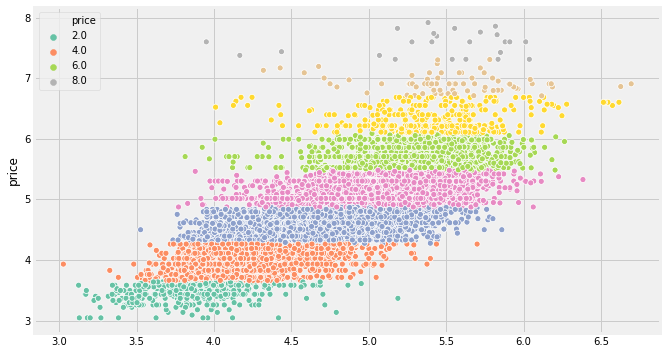

In [238]:
plt.figure(figsize=(10,6))
sns.scatterplot(predictions,y_test,hue=y_test, palette = "Set2")
plt.ioff()

# Conclussion:
### The results are not the best, 67% of R2 score, we need more data to obtain better results, the features in the dataset are not enough to get a higher score.